# Uso de Redes Neurais para Classificar a Vitória em Rodadas de Counter-Strike 2

## Como executar
É necessário ter Python e os pacotes que serão utilizados neste trabalho instalados. Python pode ser instalado através da página web do python (https://www.python.org/downloads/) e os pacotes recomendamos a instalação via pip, um dos gerenciadores de pacotes do python. Para os pacotes os comandos com pip ficam `pip install scikit-learn`, `pip install matplotlib` e `pip install seaborn`
Para executar o código de uma véz é possível rodar todos os trechos de código em sequência, ao final estará o print da acurácia e matriz de confusão.\
Após executar todo o código uma vez é possivel treinar novamente a IA e mostrar as novas informações é necessário somente rodar o último bloco de código.

## Informações sobre cada trecho acompanha cada bloco de código
Imports necessários para execução dos códigos

In [77]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Classes para representar os objetos e funções de retorno dos valores de relevancias designados a cada elemento do jogo

In [78]:
def returnWeaponValue(weapon):
    if weapon == "DESERT-EAGLE":
        return 2

    elif weapon == "R8 REVOLVER":
        return 2

    elif weapon == "DUAL-BERETTAS":
        return 2

    elif weapon == "FIVE-SEVEN":
        return 2

    elif weapon == "GLOCK-18":
        return 1

    elif weapon == "P2000":
        return 1

    elif weapon == "USP-S":
        return 1

    elif weapon == "P250":
        return 2

    elif weapon == "CZ75-AUTO":
        return 2

    elif weapon == "TEC-9":
        return 2

    elif weapon == "MAG-7":
        return 2

    elif weapon == "NOVA":
        return 2

    elif weapon == "SAWED-OFF":
        return 2

    elif weapon == "XM1014":
        return 3

    elif weapon == "PP-BIZON":
        return 2

    elif weapon == "MAC-10":
        return 3

    elif weapon == "MP7":
        return 2

    elif weapon == "MP5-SD":
        return 2

    elif weapon == "MP9":
        return 3

    elif weapon == "P90":
        return 2

    elif weapon == "UMP-45":
        return 3

    elif weapon == "AK-47":
        return 4

    elif weapon == "AUG":
        return 4

    elif weapon == "FAMAS":
        return 3

    elif weapon == "GALIL-AR":
        return 3

    elif weapon == "M4A4":
        return 4

    elif weapon == "M4A1":
        return 4

    elif weapon == "SG-553":
        return 4

    elif weapon == "M249":
        return 3

    elif weapon == "NEGEV":
        return 2

    elif weapon == "AWP":
        return 10

    elif weapon == "G3SG1":
        return 4

    elif weapon == "SCAR-20":
        return 4

    elif weapon == "SSG-08":
        return 3

def returnDefuseValue(defuse):
    if defuse == "Nao":
        return -1
    return 1

def returnArmorValue(armor):
    if armor == "Kevlar":
        return 1
    if armor == "Kevlar + Helmet":
        return 2;
    if armor == "No Armor":
        return 0

def returnGranadeValue(grenade):
    if grenade == "HE" or grenade == " HE":
        return 1
    if grenade == "Smoke" or grenade == " Smoke":
        return 5
    if grenade == "Flashbang" or grenade == " Flashbang":
        return 3
    if grenade == "Molotov":
        return 5
    return 0

class Player:
    def __init__(self, name, defuse, armor, weapon, grenades):
        self.name = name
        self.defuse = returnDefuseValue(defuse)
        self.armor = returnArmorValue(armor)
        self.weapon = weapon
        self.grenades = 0
        i = 0
        for grenade in grenades:
            new_grenade = returnGranadeValue(grenade)
            self.grenades = self.grenades + new_grenade
            i+= 1
        return

    def printPlayer(self):
        print("Name: ", self.name)
        print("Defuse: ", self.defuse)
        print("Armor: ", self.armor)
        print("Weapon: ", self.weapon)
        print("Grenades: ", self.grenades)
        print("--------------------------")

class Team:
    def __init__(self, players):
        self.player = players

    def printTeam(self):
        for player in self.player:
            player.printPlayer()

class Round:
    def __init__(self, winner, team1, team2):
        self.winner = winner
        self.team0 = team1
        self.team1 = team2

    def printRound(self):
        print()
        print()
        print("Winner: Team ", self.winner)
        print("Team 0:")
        self.team0.printTeam()
        print()
        print("Team 1:")
        self.team1.printTeam()

Funções para separaçãoe e organização dos times, a necessidade dessas funções será explicada mais a frente

In [79]:
def isPistolRound(team0, team1):
    if teamIsPistol(team0) and teamIsPistol(team1):
        return True
    else:
        return False

def teamIsPistol(team):
    weapon_value = 0
    for player in team.player:
        weapon = returnWeaponValue(player.weapon)
        weapon_value = weapon_value + weapon
        
    if weapon_value <= 7:
        return True
    else:
        return False

def isTR(team):
    for player in team.player:
        if player.weapon == "GLOCK-18":
            return True
    return False

def setTeam0asCT(round):
    round.team0, round.team1 = round.team1, round.team0

    if round.winner == 0:
        round.winner = 1

Funções de soma para cada elemento dos times

In [80]:
def weaponSum(team):
    sum = 0
    for player in team.player:
        sum += returnWeaponValue(player.weapon)
    return sum

def grenadeSum(team):
    sum = 0
    for player in team.player:
        sum += player.grenades
    return sum

def armorSum(team):
    sum = 0
    for player in team.player:
        sum += player.armor
    return sum

def defuseSum(team):
    sum = 0
    for player in team.player:
        sum += player.defuse
    return sum

def media(valores):
    return sum(valores) / len(valores)

Extração e categorização dos dados brutos de cada time

In [81]:
winner = []
rounds = []
j = 0;

with open('input.txt', 'r') as file:
    lines = file.readlines()

for i in range(0, len(lines), 11):
    winner_line = lines[i].strip()
    if winner_line == 'Time 0':
        winner.append(0)
    else:
        winner.append(1)

    team1 = []
    team2 = []

    for line in lines[i + 1:i + 6]:
        line = line.strip()
        parts = line.split(';')
        name = parts[0].strip()
        defuse = parts[1].strip()
        armor = parts[2].strip()
        weapon = parts[3].strip()
        grenades = parts[4].strip().split(',') if len(parts) > 1 else []

        player = Player(name, defuse, armor, weapon, grenades)
        team1.append(player)

    for line in lines[i + 6:i + 11]:
        line = line.strip()
        parts = line.split(';')
        name = parts[0].strip()
        defuse = parts[1].strip()
        armor = parts[2].strip()
        weapon = parts[3].strip()
        grenades = parts[4].strip().split(',') if len(parts) > 1 else []

        player = Player(name, defuse, armor, weapon, grenades)
        team2.append(player)

    time1 = Team(team1)
    time2 = Team(team2)

    rounds.append(Round(winner[j], time1, time2))
    j+= 1

Os dados dos jogos foram pegos em sequência das rodadas, seguindo a ordem padrão do jogo, porém, em todos os jogos, na rodada 13, os times trocam de lado, mudança não representada em local algum na base de dados, não trocando a ordem com que os times aparecem, ou seja, se o time 1 começou como CT, ele vai acabar o jogo como TR ainda na posição um. Para fazer a separação dos times e enviar os dados para a MLP, definimos que o time 0 sempre será CT, portanto sempre que o jogo chega no round 13, verificamos se o time 0 é TR, caso ele seja, trocamos os times de posição. Também não foi inserido nenhuma linha que identifica-se o fim de cada partida, ou seja, após o fim do jogo outro jogo era escolhido em sequência sem nada para informar que o jogo anterior acabou, portanto procuramos quando um round pistol, round que acontece na primeira e na décima terceira rodada, ocorre após a décima quarta rodada do inicio da partida, informação que indicará o inicio de uma nova rodada, ou seja, paramos de procura-la, voltando ao inicio do loop e, caso necessário, invertendo a posição dos times.

In [82]:
i = 0
sampleSize = len(rounds) - 1

while i < sampleSize:
    if isTR(rounds[i].team0):
        setTeam0asCT(rounds[i])
    i += 13

    if i >= len(rounds):
        break

    if isTR(rounds[i].team0):
        setTeam0asCT(rounds[i])

    while i < sampleSize and not isPistolRound(rounds[i].team0, rounds[i].team1):
        i += 1

Codificamos os dados recolhidos para inserção na MLP e adicionamos em listas. Aqui também separamos os dados em set de treinamento e set de testes, onde deixamos 80% das entradas como sendo para treinar a rede e 20% para realizar testes poseteriores. Com o random_state definido para um valor, garantimos que sempre que está função sejá executada com o mesmo valor definido os sets gerados sejam iguais.

In [83]:
round = []
winner = []

for rodada in rounds:
    team0_weapon_sum = weaponSum(rodada.team0)
    team0_grenade_sum = grenadeSum(rodada.team0)
    team0_armor_sum = armorSum(rodada.team0)
    team0_defuse_sum = defuseSum(rodada.team0)
    team1_weapon_sum = weaponSum(rodada.team1)
    team1_grenade_sum = grenadeSum(rodada.team1)
    team1_armor_sum = armorSum(rodada.team1)
    overallRound = [team0_weapon_sum, team0_grenade_sum, team0_armor_sum, team0_defuse_sum, team1_weapon_sum, team1_grenade_sum, team1_armor_sum]
    round.append(overallRound)
    winner.append(rodada.winner)

set_treino, set_teste, result_treino, result_teste = train_test_split(round, winner, test_size=0.2, random_state=10)

Criamos um MLP com com duas camads ocultas, contendo 13 e 9 neuronios em suas camadas, respectivamente, iteramos no máximo 100000 sob uma taxa de aprendizado constante 0.001.
\
\
Após treina-la, printamos a acurácia e plotamos um gráfico representando a matriz de confusão.

Número de neurônios na camada de saída: 1
Acuracia do modelo com 13 e 9 camadas escondidas: 0.5289256198347108



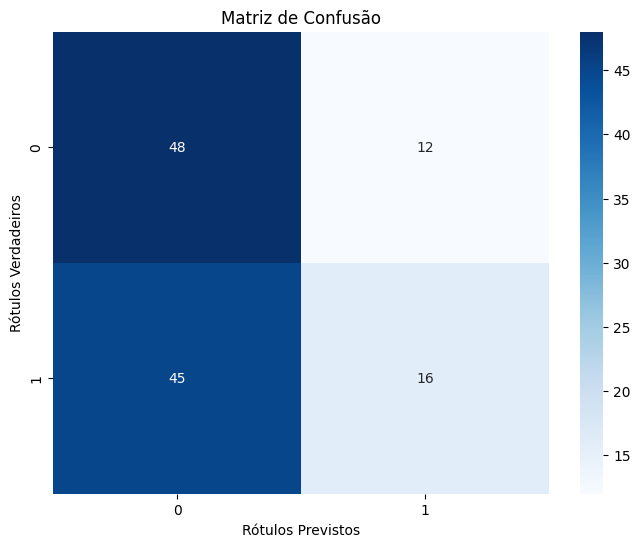

In [84]:
hiperparametros = {
    'hidden_layer_sizes': [(13, 4)],
    'activation': ['relu', 'relu'],
    'solver': ['adam', 'adam'],
    'learning_rate_init': [0.001],
    'max_iter': [100000]
}

modelo = MLPClassifier()

mlp = GridSearchCV(modelo, hiperparametros, cv=3, scoring='accuracy')

mlp.fit(set_treino, result_treino)

result_predicao = mlp.predict(set_teste)

accuracy = (accuracy_score(result_teste, result_predicao))

print("Número de neurônios na camada de saída:", num_neuronios_saida)
print(f"Acuracia do modelo com {13} e {9} camadas escondidas: {accuracy}\n")

matriz_confusao = confusion_matrix(result_teste, result_predicao)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()